In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

24/10/08 23:35:01 WARN Utils: Your hostname, DESKTOP-AEUBGUH resolves to a loopback address: 127.0.1.1; using 172.21.144.1 instead (on interface eth1)
24/10/08 23:35:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 23:35:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
pd_df = pd.read_parquet("../data/clean_data/df_trans_sent_comments.parquet")
df = spark.createDataFrame(pd_df)

In [4]:
df.show()

24/10/08 23:35:29 WARN TaskSetManager: Stage 0 contains a task of very large size (6407 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+--------------------+----------+-------------------+-------------------+---------------+-----------+--------------------+--------------------+---------+
|          comment_id|              author|   author_channel_id|                text|like_count|       published_at|         updated_at|totalReplyCount|   video_id|         translation|          clean_text|sentiment|
+--------------------+--------------------+--------------------+--------------------+----------+-------------------+-------------------+---------------+-----------+--------------------+--------------------+---------+
|UgxqJ2eO2p7w2NEvB...|  @emmanuelamama1991|UCdUooL3DTt3Wj0M3...|great video,helpful.|       1.0|2024-08-17 15:07:48|2024-08-17 15:07:48|            1.0|qtlUwwtvuEg|great video,helpful.|  great videohelpful|   0.6249|
|UgzmXwaNzivNHqjfR...|   @dr.alexshayo6972|UCN56M0YoTn18rd_K...|Thank you for suc...|       4.0|2023-05-01 16:48:21|2023-05-01 16:48

In [5]:
from transformers import pipeline
from pyspark.sql.functions import udf

sentiment_model = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

def get_sentiment(text):
    try:
        sentiment = sentiment_model(text)
        return sentiment
    except Exception as e:
        return str(e)

sentiment_udf = udf(get_sentiment)

/home/ivanseldasp/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# df_limited = df.limit(10000)

df_with_sentiment = df.withColumn("emotions", sentiment_udf(df['translation']))

df_with_sentiment.show(truncate=False)

24/10/08 23:36:18 WARN TaskSetManager: Stage 1 contains a task of very large size (6407 KiB). The maximum recommended task size is 1000 KiB.
/home/ivanseldasp/.local/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fi

+--------------------------+-----------------------------+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------+-------------------+---------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
emotions_column = df_with_sentiment.select('emotions').limit(10)

In [8]:
emotions_column.show()

24/10/08 23:36:32 WARN TaskSetManager: Stage 2 contains a task of very large size (6407 KiB). The maximum recommended task size is 1000 KiB.
/home/ivanseldasp/.local/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fi

+--------------------+
|            emotions|
+--------------------+
|[[{score=0.953117...|
|[[{score=0.990995...|
|[[{score=0.988971...|
|[[{score=0.941890...|
|[[{score=0.986132...|
|[[{score=0.965435...|
|[[{score=0.984012...|
|[[{score=0.747151...|
|[[{score=0.990160...|
|[[{score=0.978443...|
+--------------------+



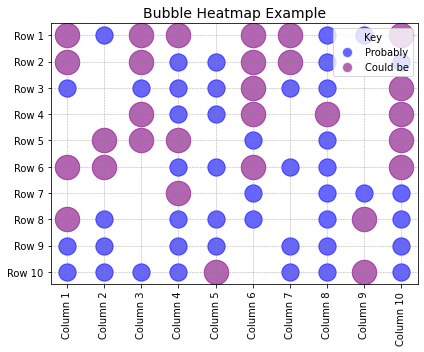

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data for a bubble heatmap
data = np.random.choice([0, 1, 2], size=(10, 10))  # Random data with values 0, 1, 2
df = pd.DataFrame(data, columns=[f"Column {i+1}" for i in range(10)], 
                  index=[f"Row {i+1}" for i in range(10)])

# Create the bubble heatmap
plt.figure(figsize=(6, 5))

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        value = df.iloc[i, j]
        if value != 0:
            plt.scatter(j, i, s=value * 300, color='blue' if value == 1 else 'purple', alpha=0.6)

# Customizing the heatmap
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=90)
plt.yticks(np.arange(df.shape[0]), df.index)
plt.gca().invert_yaxis()  # To match the orientation

plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Creating a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Probably', markersize=10, 
                               markerfacecolor='blue', alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='Could be', markersize=10, 
                               markerfacecolor='purple', alpha=0.6)]

plt.legend(handles=legend_elements, title='Key', loc='upper right')

plt.title('Bubble Heatmap Example', fontsize=14)
plt.tight_layout()
plt.show()

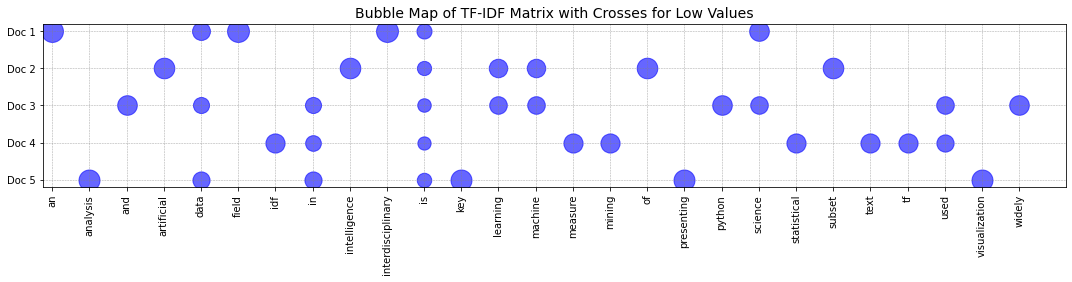

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Sample text data
documents = [
    "Data science is an interdisciplinary field.",
    "Machine learning is a subset of artificial intelligence.",
    "Python is widely used in data science and machine learning.",
    "TF-IDF is a statistical measure used in text mining.",
    "Visualization is key in presenting data analysis."
]

# Generate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Define a threshold for low values
low_value_threshold = 0.1

# Creating a bubble map
plt.figure(figsize=(15, 10))

# Iterate over the DataFrame to create the bubble map with crosses for low values
for row_idx in range(tfidf_df.shape[0]):
    for col_idx in range(tfidf_df.shape[1]):
        value = tfidf_df.iloc[row_idx, col_idx]
        if value > 0:
            # Plot bubbles for non-zero values
            plt.scatter(col_idx, row_idx, s=value * 1000, alpha=0.6, color='blue')
            # Plot a cross for low TF-IDF values
            if value < low_value_threshold:
                plt.scatter(col_idx, row_idx, s=100, marker='x', color='red', alpha=0.8, linewidths=2)

# Customizing the bubble map
plt.xticks(np.arange(tfidf_df.shape[1]), tfidf_df.columns, rotation=90)
plt.yticks(np.arange(tfidf_df.shape[0]), [f"Doc {i+1}" for i in range(tfidf_df.shape[0])])
plt.gca().invert_yaxis()  # To match the heatmap orientation
plt.gca().set_aspect('equal', adjustable='box')


plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Title and layout adjustments
plt.title('Bubble Map of TF-IDF Matrix with Crosses for Low Values', fontsize=14)
plt.tight_layout()
plt.show();

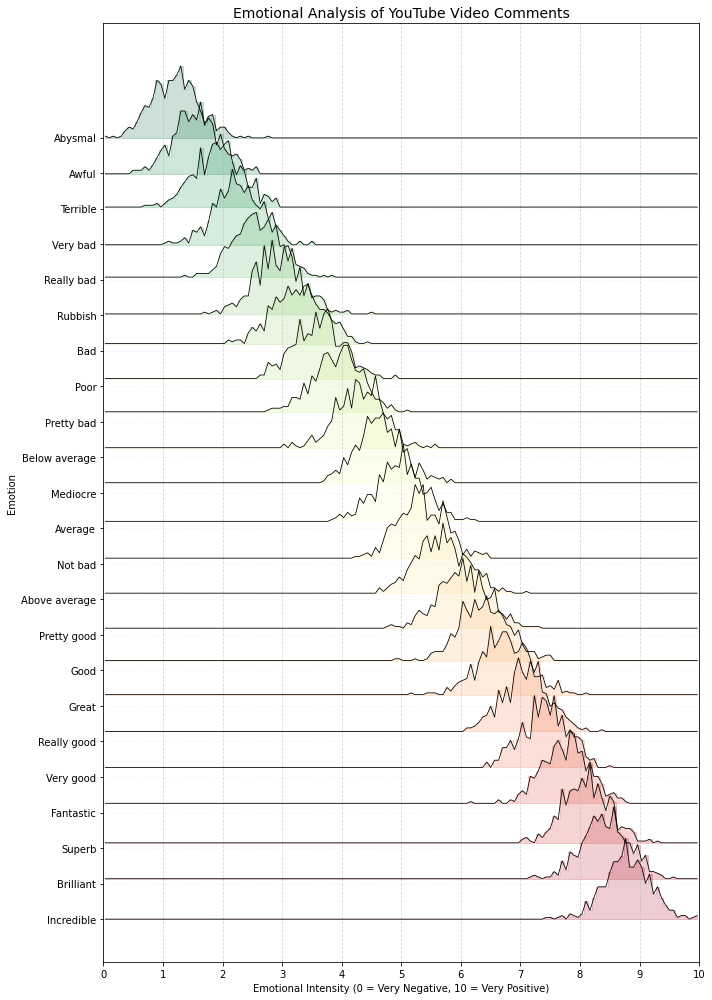

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Crear los datos de ejemplo similares al gráfico que compartiste
emotions = [
    "Abysmal", "Awful", "Terrible", "Very bad", "Really bad", "Rubbish", "Bad", "Poor", 
    "Pretty bad", "Below average", "Mediocre", "Average", "Not bad", "Above average", 
    "Pretty good", "Good", "Great", "Really good", "Very good", "Fantastic", "Superb", 
    "Brilliant", "Incredible"
]
average_scores = np.linspace(1.2, 8.8, len(emotions))

# Creamos una lista de distribuciones ficticias para cada emoción
np.random.seed(42)
data = {
    'score': np.concatenate([np.random.normal(loc=avg, scale=0.4, size=500) for avg in average_scores]),
    'emotion': np.concatenate([[emotion] * 500 for emotion in emotions])
}

df = pd.DataFrame(data)
df['score'] = df['score'].clip(0, 10)  # Limitar valores de score entre 0 y 10

# Crear el gráfico estilo joyplot manualmente asegurando el desplazamiento vertical y la alineación con la cuadrícula
plt.figure(figsize=(10, 14))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(emotions)))

# Configuración del desplazamiento para permitir superposición y alineación
offset = 0
overlap_factor = 0.5  # Ajusta este factor para la superposición

# Generar los datos de densidad para cada emoción
for i, emotion in enumerate(reversed(emotions)):
    subset = df[df['emotion'] == emotion]
    density, bins = np.histogram(subset['score'], bins=150, range=(0, 10), density=True)
    bins_center = 0.5 * (bins[1:] + bins[:-1])

    # Dibujar el área sombreada con color y permitir superposición
    plt.fill_between(bins_center, offset, density + offset, color=colors[i], alpha=0.2, step='mid')
    
    # Dibujar la línea de la curva de densidad sobre el área coloreada
    plt.plot(bins_center, density + offset, color='black', linewidth=0.8)
    
    # Incrementar el offset para la siguiente línea permitiendo superposición y alineación con la cuadrícula
    offset += max(density) * overlap_factor  

# Configuraciones del gráfico
plt.yticks(np.arange(0, offset, offset / len(emotions)), reversed(emotions))  # Asegurar alineación
plt.xticks(np.arange(0, 11, 1))  # Alinear los ticks del eje x con la cuadrícula
plt.xlabel("Emotional Intensity (0 = Very Negative, 10 = Very Positive)")
plt.ylabel("Emotion")
plt.title("Emotional Analysis of YouTube Video Comments", fontsize=14)
plt.xlim(0, 10)

# Mejorar la visualización de la cuadrícula
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle=':', alpha=0.2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()